In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.ticker as ticker
import logging

logging.getLogger("matplotlib.font_manager").setLevel(logging.ERROR)

fontpath = "/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf"
fontprop = fm.FontProperties(fname=fontpath, size=12)
plt.rcParams["font.family"] = fontprop.get_name()

print(f"설정된 폰트: {fontprop.get_name()}")

설정된 폰트: NanumBarunGothic


In [2]:
# 데이터 전처리
import os
import re
import urllib.request
import zipfile
import sentencepiece as spm
import pandas as pd

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset

from tqdm import tqdm
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.__version__)

2.7.1+cu118


In [3]:
dataset_dir = os.path.join(os.path.expanduser("~"), "datasets", "spa-eng")
os.makedirs(dataset_dir, exist_ok=True)
zip_path = os.path.join(dataset_dir, "spa-eng.zip")

if not os.path.exists(zip_path):
    print("데이터 다운로드 중...")
    url = "http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip"
    urllib.request.urlretrieve(url, zip_path)
    print("다운로드 완료!")

data_folder = os.path.join(dataset_dir, "spa-eng")
if not os.path.exists(data_folder):
    print("압축 해제 중...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(dataset_dir)
    print("압축 해제 완료!")

path_to_file = os.path.join(data_folder, "spa.txt")

print("데이터셋 디렉토리:", os.listdir(dataset_dir))

데이터 다운로드 중...
다운로드 완료!
압축 해제 중...
압축 해제 완료!
데이터셋 디렉토리: ['spa-eng', 'spa-eng.zip']


In [4]:
df = pd.read_csv(path_to_file, sep = "\t", names = ["eng", "spa"])
df.head()

,eng,spa
0,Go.,Ve.
1,Go.,Vete.
2,Go.,Vaya.
3,Go.,Váyase.
4,Hi.,Hola.


In [5]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)

    sentence = sentence.strip()

    return sentence

In [6]:
#df = df[:30000]

df["eng"] = df["eng"].apply(preprocess_sentence)
df["spa"] = df["spa"].apply(lambda x: preprocess_sentence(x))

df.head()

,eng,spa
0,go .,ve .
1,go .,vete .
2,go .,vaya .
3,go .,v yase .
4,hi .,hola .


In [7]:
df["eng"].to_csv("eng_corpus.txt", index=False, header=False, sep="\n", encoding="utf-8")
df["spa"].to_csv("spa_corpus.txt", index=False, header=False, sep="\n", encoding="utf-8")

print("파일 저장 완료: eng_corpus.txt, spa_corpus.txt")

파일 저장 완료: eng_corpus.txt, spa_corpus.txt


In [8]:
vocab_size = 3000
pad_id = 0
bos_id = 1
eos_id = 2
unk_id = 3

spm.SentencePieceTrainer.train(
    input = "eng_corpus.txt",
    model_prefix = "encoder_spm",
    vocab_size = vocab_size,
    pad_id = pad_id,
    bos_id = bos_id,
    eos_id = eos_id,
    unk_id = unk_id
)

spm.SentencePieceTrainer.train(
    input = "spa_corpus.txt",
    model_prefix = "decoder_spm",
    vocab_size = vocab_size,
    pad_id = pad_id,
    bos_id = bos_id,
    eos_id = eos_id,
    unk_id = unk_id
)

sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: eng_corpus.txt
  input_format: 
  model_prefix: encoder_spm
  model_type: UNIGRAM
  vocab_size: 3000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 3
  bos_id: 1
  eos_id: 2
  pad_id: 0
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
  enable_differential_privacy: 0
  d

In [9]:
encoder_tokenizer = spm.SentencePieceProcessor()
encoder_tokenizer.load("encoder_spm.model")

decoder_tokenizer = spm.SentencePieceProcessor()
decoder_tokenizer.load("decoder_spm.model")

True

In [10]:
df

,eng,spa
0,go .,ve .
1,go .,vete .
2,go .,vaya .
3,go .,v yase .
4,hi .,hola .
...,...,...
118959,there are four main causes of alcohol related ...,hay cuatro causas principales de muertes relac...
118960,there are mothers and fathers who will lie awa...,hay madres y padres que se quedan despiertos d...
118961,a carbon footprint is the amount of carbon dio...,una huella de carbono es la cantidad de contam...
118962,since there are usually multiple websites on a...,como suele haber varias p ginas web sobre cual...


In [11]:
eng_sample = df["eng"][10000]
spa_sample = df["spa"][10000]
print(eng_sample)
print(spa_sample)

do you like fish ?
te gusta el pescado ?


In [12]:
enc_token = encoder_tokenizer.encode(eng_sample)
enc_token = [encoder_tokenizer.bos_id()] + enc_token + [encoder_tokenizer.eos_id()]
enc_token

[1, 28, 10, 52, 401, 15, 2]

In [13]:
enc_decoding = encoder_tokenizer.decode(enc_token)
enc_decoding

'do you like fish ?'

In [14]:
class TranslationDataset(Dataset):
    def __init__(self, data, encoder_tokenizer, decoder_tokenizer, max_len):
        self.data = data
        self.encoder_tokenizer = encoder_tokenizer
        self.decoder_tokenizer = decoder_tokenizer
        self.max_len = max_len
        self.pad_id = 0
        self.bos_id = 1
        self.eos_id = 2

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        src_text = self.data.iloc[idx]['eng']
        trg_text = self.data.iloc[idx]['spa']

        src_ids = self.encoder_tokenizer.encode(src_text)
        trg_ids = self.decoder_tokenizer.encode(trg_text)

        src_ids = src_ids[:self.max_len]

        # Decoder의 입력에는 START_TOKEN과 END_TOKEN을 추가해줍니다. 단, 최대 길이 제한을 적용시킵니다.
        trg_input = [self.bos_id] + trg_ids[:self.max_len - 2] + [self.eos_id]
        trg_label = trg_ids[:self.max_len - 1] + [self.eos_id]

        # 길이가 짧은 경우 PAD_TOKEN을 추가해줍니다.
        src_ids = src_ids + [self.pad_id] * (self.max_len - len(src_ids))
        trg_input = trg_input + [self.pad_id] * (self.max_len - len(trg_input))
        trg_label = trg_label + [self.pad_id] * (self.max_len - len(trg_label))

        return torch.tensor(src_ids), torch.tensor(trg_input), torch.tensor(trg_label)

In [15]:
train_ratio = 0.8  # 전체 길이의 80%
MAX_LEN = 30 # 임의의 값
BATCH_SIZE = 64

train_data = df.sample(frac=train_ratio, random_state=42)  # 70% 훈련 데이터
valid_data = df.drop(train_data.index)

train_data.reset_index(drop=True, inplace=True)
valid_data.reset_index(drop=True, inplace=True)

train_data = TranslationDataset(train_data, encoder_tokenizer, decoder_tokenizer, max_len=MAX_LEN)
validataion_data = TranslationDataset(valid_data, encoder_tokenizer, decoder_tokenizer, max_len=MAX_LEN)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(validataion_data, batch_size=BATCH_SIZE, shuffle=False)

In [16]:
for src, trg_input, trg_label in train_loader:
    print(src.shape, trg_input.shape, trg_label.shape)
    break

torch.Size([64, 30]) torch.Size([64, 30]) torch.Size([64, 30])


In [17]:
# 모델 설계
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()

        self.W1 = nn.Linear(hidden_dim, hidden_dim)
        self.W2 = nn.Linear(hidden_dim, hidden_dim)
        self.v = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        # hidden: (batch_size, hidden_dim)
        # encoder_outputs: (src_len, batch_size, hidden_dim)

        src_len = encoder_outputs.shape[0]

        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)  # (batch_size, src_len, hidden_dim)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)  # (batch_size, src_len, hidden_dim)

        energy = torch.tanh(self.W1(encoder_outputs) + self.W2(hidden))  # (batch_size, src_len, hidden_dim)
        attention = self.v(energy).squeeze(2)  # (batch_size, src_len)

        return nn.functional.softmax(attention, dim=1)  # (batch_size, src_len)

In [18]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hidden_dim):
        super().__init__()

        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, hidden_dim)

    def forward(self, src):
        # src : (src_len, batch_size)
        embedded = self.embedding(src)  # embedded : (src_len, batch_size, emb_dim)
        outputs, hidden = self.rnn(embedded)  # outputs : (src_len, batch_size, hidden_dim)

        return outputs, hidden

In [19]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hidden_dim, attention):
        super(Decoder, self).__init__()

        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, emb_dim)
        # Decoder RNN에는 embedding만 입력
        self.rnn = nn.GRU(emb_dim, hidden_dim)
        # 출력층에는 hidden state와 attention value가 결합되어 입력
        self.fc_out = nn.Linear(hidden_dim + hidden_dim, output_dim)

    def forward(self, input, hidden, encoder_outputs):
        # input : (batch_size,)
        # hidden : (batch_size, hidden_dim)
        # encoder_outputs : (src_len, batch_size, hidden_dim)
        input = input.unsqueeze(0)  # input : (1, batch_size)
        embedded = self.embedding(input)  # embedded : (1, batch_size, emb_dim)

        # attention distribution을 계산합니다. decoder의 이전 hidden state, s_{t-1}와 encoder의 H가 입력됩니다.
        a = self.attention(hidden[-1], encoder_outputs)  # a : (batch_size, src_len)

        # H에 가중치를 부여해 attention value(Context vector) 계산
        a = a.unsqueeze(1)  # a : (batch_size, 1, src_len)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)  # encoder_outputs : (batch_size, src_len, hidden_dim)
        context = torch.bmm(a, encoder_outputs)  # context : (batch_size, 1, hidden_dim)
        context = context.permute(1, 0, 2)  # context : (1, batch_size, hidden_dim)

        output, hidden = self.rnn(embedded, hidden)

        # 출력층에서는 현재 hidden state와 context vector를 결합하여 예측값 생성
        output = output.squeeze(0)  # output : (batch_size, hidden_dim)
        context = context.squeeze(0)  # context : (batch_size, hidden_dim)
        prediction = self.fc_out(torch.cat((output, context), dim=1))  # (batch_size, output_dim)

        return prediction, hidden, a.squeeze(1)

In [20]:
class Seq2SeqAttention(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg=None, max_len=30, bos_id = 1, eos_id=2):
        # 학습 모드에서는 trg_len 사용, 추론 모드에서는 max_len까지 동적 생성
        batch_size = src.shape[1]
        trg_vocab_size = self.decoder.fc_out.out_features

        # 조기 종료를 위해 tensor가 아닌 리스트 사용
        outputs = []

        # 시각화를 위해 attention 저장
        attentions = []

        # 인코더를 통해 context 생성
        encoder_outputs, hidden = self.encoder(src)

        if trg is not None:
            for t in range(0, trg.shape[0]):
                input = trg[t]
                output, hidden, attention = self.decoder(input, hidden, encoder_outputs)
                outputs.append(output.unsqueeze(0))
                attentions.append(attention.unsqueeze(0))

        else:
		    # inference에서는 target(정답)이 없기 때문에 sos_token을 생성해줍니다.
            input = torch.full((batch_size,), bos_id, dtype=torch.long, device=self.device)
            finished = torch.zeros(batch_size, dtype=torch.bool, device=self.device)

            for t in range(max_len):
                output, hidden, attention = self.decoder(input, hidden,  encoder_outputs)
                outputs.append(output.unsqueeze(0))
                attentions.append(attention.unsqueeze(0))
                top1 = output.argmax(1)
                input = top1

                # 조기 종료 조건
                finished |= (top1 == eos_id)
                if finished.all():
                    break

        outputs = torch.cat(outputs, dim=0)  # (trg_len, batch_size, output_dim)
        attentions = torch.cat(attentions, dim=0)  # (trg_len, batch_size, src_len)

        return outputs, attentions

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_dim = len(encoder_tokenizer)
output_dim = len(decoder_tokenizer)
emb_dim = 256
hid_dim = 512

In [22]:
encoder = Encoder(input_dim, emb_dim, hid_dim).to(device)
attention = BahdanauAttention(hid_dim).to(device)
decoder = Decoder(output_dim, emb_dim, hid_dim, attention).to(device)
model = Seq2SeqAttention(encoder, decoder, device).to(device)

In [23]:
print(model)

Seq2SeqAttention(
  (encoder): Encoder(
    (embedding): Embedding(3000, 256)
    (rnn): GRU(256, 512)
  )
  (decoder): Decoder(
    (attention): BahdanauAttention(
      (W1): Linear(in_features=512, out_features=512, bias=True)
      (W2): Linear(in_features=512, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(3000, 256)
    (rnn): GRU(256, 512)
    (fc_out): Linear(in_features=1024, out_features=3000, bias=True)
  )
)


In [24]:
# 훈련하기
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss(ignore_index=pad_id)

In [25]:
def train_step(model, data_loader, optimizer, criterion, epoch):
    model.train()
    epoch_loss = 0

    progress_bar = tqdm(data_loader, desc=f"Epoch {epoch+1}", leave=True)

    for src, trg_input, trg_label in progress_bar:
        src, trg_input, trg_label = src.to(device), trg_input.to(device), trg_label.to(device)
        optimizer.zero_grad()

        outputs,_ = model(src, trg_input)

        # (trg_len, batch_size, output_dim)을 (batch_size * trg_len, output_dim)으로 변환
        outputs = outputs.view(-1, outputs.shape[-1])
        trg_label = trg_label.view(-1)

        loss = criterion(outputs, trg_label)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

        optimizer.step()

        epoch_loss += loss.item()

        progress_bar.set_postfix(loss=loss.item())

    return epoch_loss / len(data_loader)

In [26]:
%%time

EPOCHS = 10

for epoch in range(EPOCHS):
    train_loss = train_step(model, train_loader, optimizer, criterion, epoch)
    print(f'Epoch {epoch+1}/{EPOCHS}, Train Loss: {train_loss:.4f}')

Epoch 1: 100%|██████████| 1488/1488 [04:46<00:00,  5.20it/s, loss=3.8] 


Epoch 1/10, Train Loss: 4.0434


Epoch 2: 100%|██████████| 1488/1488 [04:47<00:00,  5.17it/s, loss=3.94]


Epoch 2/10, Train Loss: 3.7171


Epoch 3: 100%|██████████| 1488/1488 [04:48<00:00,  5.16it/s, loss=3.95]


Epoch 3/10, Train Loss: 3.6256


Epoch 4: 100%|██████████| 1488/1488 [04:50<00:00,  5.11it/s, loss=4.06]


Epoch 4/10, Train Loss: 3.5553


Epoch 5: 100%|██████████| 1488/1488 [04:52<00:00,  5.08it/s, loss=4.79]


Epoch 5/10, Train Loss: 3.4938


Epoch 6: 100%|██████████| 1488/1488 [04:51<00:00,  5.11it/s, loss=3.18]


Epoch 6/10, Train Loss: 3.4358


Epoch 7: 100%|██████████| 1488/1488 [04:50<00:00,  5.12it/s, loss=3.62]


Epoch 7/10, Train Loss: 3.3816


Epoch 8: 100%|██████████| 1488/1488 [04:48<00:00,  5.15it/s, loss=3.09]


Epoch 8/10, Train Loss: 3.3245


Epoch 9: 100%|██████████| 1488/1488 [04:48<00:00,  5.16it/s, loss=3.98]


Epoch 9/10, Train Loss: 3.2758


Epoch 10: 100%|██████████| 1488/1488 [04:50<00:00,  5.12it/s, loss=3.7] 

Epoch 10/10, Train Loss: 3.2300
CPU times: user 48min 8s, sys: 22.2 s, total: 48min 30s
Wall time: 48min 16s


In [27]:
def eval_step(model, data_loader, optimizer, criterion):
    model.eval()
    total_loss = 0

    for src, trg_input, trg_label in data_loader:
        src, trg_input, trg_label = src.to(device), trg_input.to(device), trg_label.to(device)

        outputs, _ = model(src, trg_input)

        # (trg_len, batch_size, output_dim)을 (batch_size * trg_len, output_dim)으로 변환
        outputs = outputs.view(-1, outputs.shape[-1])
        trg_label = trg_label.view(-1)

        loss = criterion(outputs, trg_label)

        total_loss += loss.item()

    return total_loss / len(data_loader)

In [28]:
%%time

EPOCHS = 20

for epoch in range(EPOCHS):
    train_loss = train_step(model, train_loader, optimizer, criterion, epoch)
    valid_loss = eval_step(model, validation_loader, optimizer, criterion)
    print(f'Epoch {epoch+1}/{EPOCHS}, Train Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f}')

Epoch 1: 100%|██████████| 1488/1488 [04:51<00:00,  5.11it/s, loss=4.53]


Epoch 1/20, Train Loss: 3.1965, Validation Loss: 3.3656


Epoch 2: 100%|██████████| 1488/1488 [04:49<00:00,  5.14it/s, loss=4.09]


Epoch 2/20, Train Loss: 3.1610, Validation Loss: 3.3479


Epoch 3: 100%|██████████| 1488/1488 [04:48<00:00,  5.15it/s, loss=3.53]


Epoch 3/20, Train Loss: 3.1335, Validation Loss: 3.4024


Epoch 4: 100%|██████████| 1488/1488 [04:49<00:00,  5.14it/s, loss=2.79]


Epoch 4/20, Train Loss: 3.1103, Validation Loss: 3.3991


Epoch 5: 100%|██████████| 1488/1488 [04:49<00:00,  5.15it/s, loss=3.86]


Epoch 5/20, Train Loss: 3.0920, Validation Loss: 3.3722


Epoch 6: 100%|██████████| 1488/1488 [04:48<00:00,  5.16it/s, loss=3.29]


Epoch 6/20, Train Loss: 3.0754, Validation Loss: 3.3889


Epoch 7: 100%|██████████| 1488/1488 [04:48<00:00,  5.16it/s, loss=3.39]


Epoch 7/20, Train Loss: 3.0576, Validation Loss: 3.3419


Epoch 8: 100%|██████████| 1488/1488 [04:50<00:00,  5.12it/s, loss=3.77]


Epoch 8/20, Train Loss: 3.0345, Validation Loss: 3.3493


Epoch 9: 100%|██████████| 1488/1488 [04:48<00:00,  5.15it/s, loss=3.52]


Epoch 9/20, Train Loss: 3.0144, Validation Loss: 3.3451


Epoch 10: 100%|██████████| 1488/1488 [04:49<00:00,  5.15it/s, loss=3.95]


Epoch 10/20, Train Loss: 3.0023, Validation Loss: 3.3436


Epoch 11: 100%|██████████| 1488/1488 [04:49<00:00,  5.14it/s, loss=3.1] 


Epoch 11/20, Train Loss: 2.9916, Validation Loss: 3.3213


Epoch 12: 100%|██████████| 1488/1488 [04:49<00:00,  5.14it/s, loss=3.5] 


Epoch 12/20, Train Loss: 2.9778, Validation Loss: 3.3515


Epoch 13: 100%|██████████| 1488/1488 [04:49<00:00,  5.14it/s, loss=3.05]


Epoch 13/20, Train Loss: 2.9662, Validation Loss: 3.3988


Epoch 14: 100%|██████████| 1488/1488 [04:48<00:00,  5.15it/s, loss=4.24]


Epoch 14/20, Train Loss: 2.9543, Validation Loss: 3.3724


Epoch 15: 100%|██████████| 1488/1488 [04:49<00:00,  5.15it/s, loss=3.61]


Epoch 15/20, Train Loss: 2.9427, Validation Loss: 3.3656


Epoch 16: 100%|██████████| 1488/1488 [04:49<00:00,  5.14it/s, loss=2.91]


Epoch 16/20, Train Loss: 2.9334, Validation Loss: 3.3573


Epoch 17: 100%|██████████| 1488/1488 [04:48<00:00,  5.16it/s, loss=3.38]


Epoch 17/20, Train Loss: 2.9241, Validation Loss: 3.3847


Epoch 18: 100%|██████████| 1488/1488 [04:48<00:00,  5.15it/s, loss=3.32]


Epoch 18/20, Train Loss: 2.9196, Validation Loss: 3.3734


Epoch 19: 100%|██████████| 1488/1488 [04:50<00:00,  5.13it/s, loss=3.91]


Epoch 19/20, Train Loss: 2.9074, Validation Loss: 3.4036


Epoch 20: 100%|██████████| 1488/1488 [04:48<00:00,  5.15it/s, loss=3.03]


Epoch 20/20, Train Loss: 2.8932, Validation Loss: 3.3345
CPU times: user 1h 44min 40s, sys: 42.9 s, total: 1h 45min 23s
Wall time: 1h 44min 55s


In [29]:
def evaluate(sentence, model, encoder_tokenizer, decoder_tokenizer, max_len=30):
    model.eval()

    sentence = preprocess_sentence(sentence)
    src_ids = encoder_tokenizer.encode(sentence)
    src_ids = src_ids[:max_len]
    src_ids = src_ids + [0] * (max_len - len(src_ids))  # 패딩 추가
    src_tensor = torch.tensor(src_ids).unsqueeze(1).to(device)  # (src_len, 1)

    with torch.no_grad():
        outputs, attentions = model(src_tensor, max_len=max_len)

    result = [decoder_tokenizer.decode([token.item()]) for token in outputs.argmax(2).squeeze(1)]

    if "<end>" in result:
        result = result[:result.index("<end>")]

    return result, sentence, attentions.squeeze(1).cpu().numpy()

In [30]:
def plot_attention(attention, sentence, predicted_sentence):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticks(range(len(sentence)))
    ax.set_xticklabels(sentence, fontdict=fontdict, rotation=90)

    ax.set_yticks(range(len(predicted_sentence)))
    ax.set_yticklabels(predicted_sentence, fontdict=fontdict)

    plt.show()

In [31]:
def translate(sentence, model, encoder_tokenizer, decoder_tokenizer, max_len=30):
    result, sentence, attention = evaluate(sentence, model, encoder_tokenizer, decoder_tokenizer, max_len)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    # Attention 크기 조정 (trg_len, src_len)
    attention = attention[:len(result), :len(sentence.split())]

    plot_attention(attention, sentence.split(), result)

Input: the most powerful man all over the world .
Predicted translation: ['el', 'mund', 'o', 'todo', 's', 'del', 'mund', 'o', '.', '']


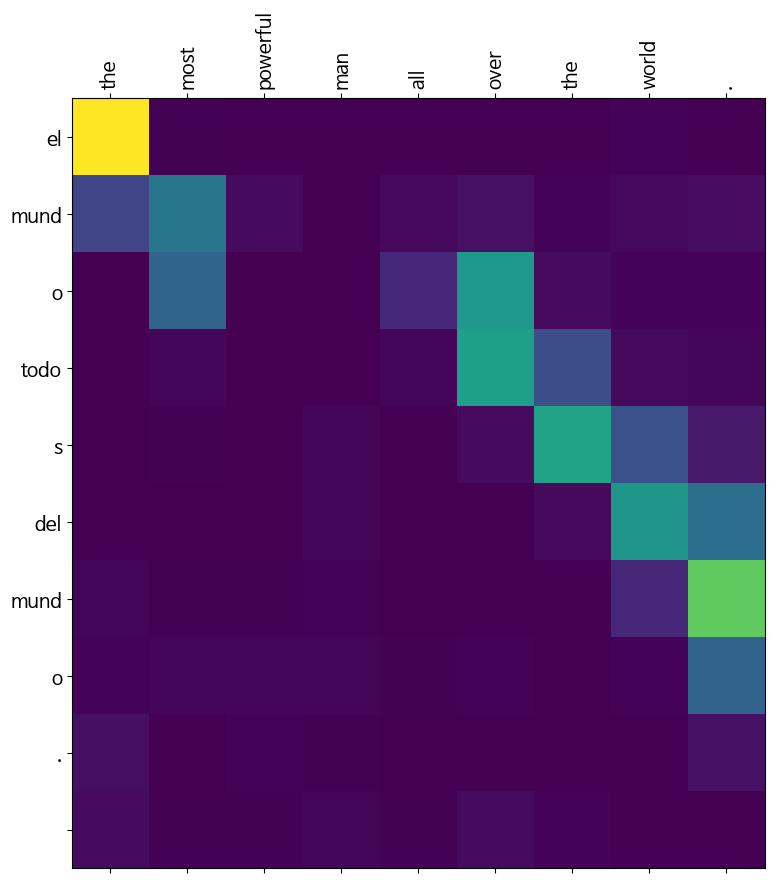

In [32]:
translate("The most powerful man all over the world.", model, encoder_tokenizer, decoder_tokenizer, max_len=30)

Input: may i help you ?
Predicted translation: ['tal', 'o', '.', '']


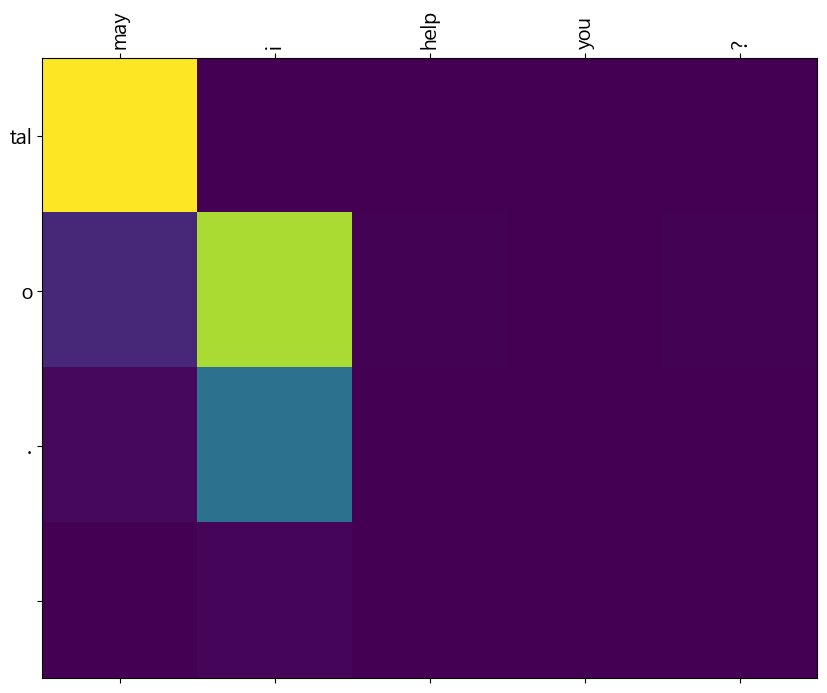

In [33]:
translate("May I help you?", model, encoder_tokenizer, decoder_tokenizer, max_len=30)

Input: can i have some coffee ?
Predicted translation: ['puede', 'que', 'yo', '.', '']


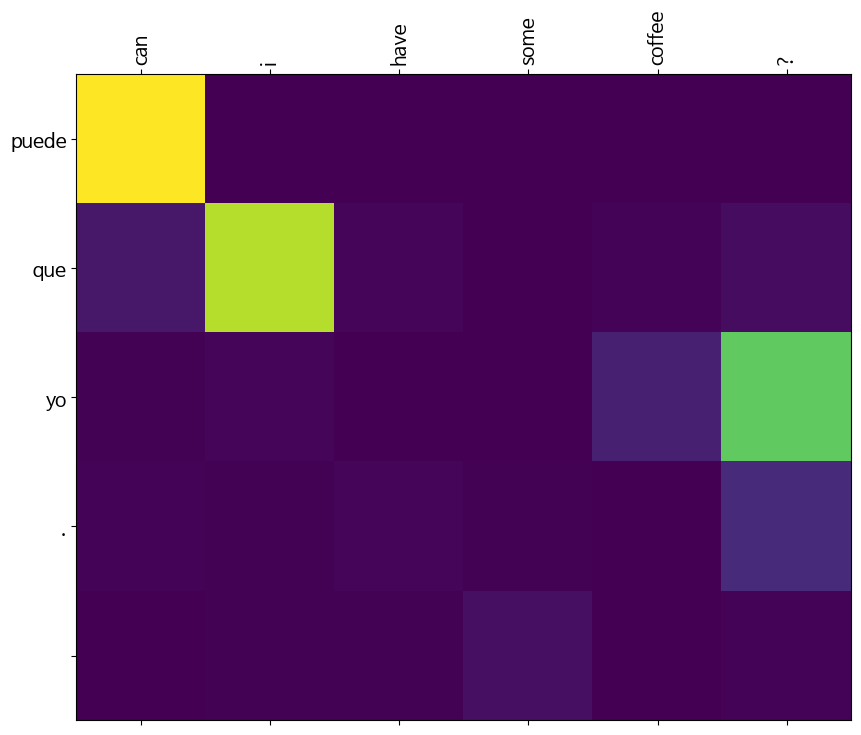

In [34]:
# 실행 예제
translate("Can I have some coffee?", model, encoder_tokenizer, decoder_tokenizer, max_len=30)